# Lasso implementation using ADMM (Alternating Direction Method of Multipliers)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend()
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

## Generate sparce signal and apply random-linear transform

In [3]:
# fix the seed of random
np.random.seed(0)

In [4]:
# Generate signal
idx = np.random.randint(0, 1000, 20)
signal = np.zeros(1000)
signal[idx] = np.random.normal(0.0, 1.0, 20)

In [5]:
# Generate observation matrix(random) and observation result
X = np.random.normal(0.0, 1.0, (100, 1000))
y = X.dot(signal)

X_test = np.random.normal(0.0, 1.0, (20, 1000))
y_test = X_test.dot(signal)

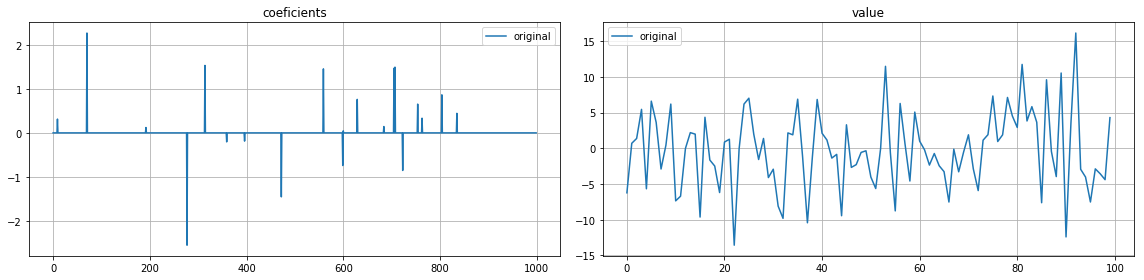

In [6]:
# Plot signal and result
show_plot(signal, y)

## Compare implementations

In [7]:
# constants
alpha = 0.1

In [8]:
import sys
sys.path.append('..')

from sklearn.linear_model import Lasso
from spmimage.linear_model import LassoADMM

In [9]:
def get_signal(model, X, y):
    model.fit(X, y)
    return model.coef_, model.predict(X)

## LASSO coordinate descent (sklearn implementation)

In [10]:
%%time
model = Lasso(alpha=alpha)
lasso_signal, lasso_predict = get_signal(model, X, y)

CPU times: user 11.4 ms, sys: 2.31 ms, total: 13.7 ms
Wall time: 12.5 ms


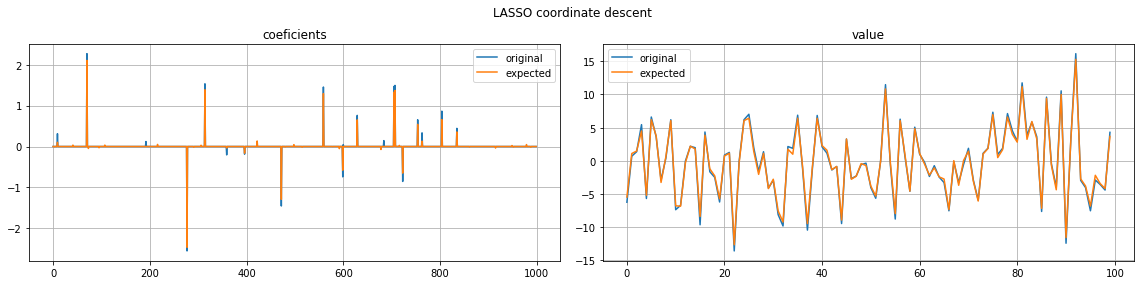

In [11]:
# Plot signal and result (sklearn)
show_plot(signal, y, lasso_signal, lasso_predict, 'LASSO coordinate descent')

## LASSO ADMM

In [12]:
%%time
model_admm = LassoADMM(alpha=alpha)
lasso_admm_signal, lasso_admm_predict = get_signal(model_admm, X, y)

CPU times: user 517 ms, sys: 44 ms, total: 561 ms
Wall time: 313 ms


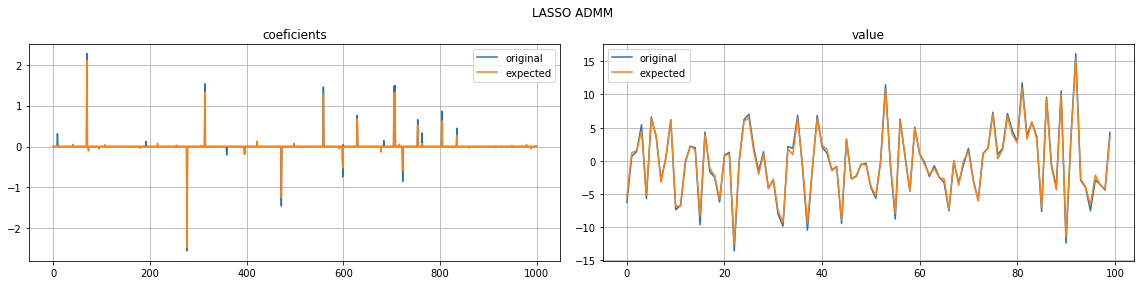

In [13]:
# Plot signal and result (ADMM)
show_plot(signal, y, lasso_admm_signal, lasso_admm_predict, 'LASSO ADMM')

## Simple comparison

* number of iterations
* precision

### Number of iterations

In [14]:
# Compare the numbers of iterations
model.n_iter_, model_admm.n_iter_

(59, 45)

### Precision

In [15]:
model.score(X_test, y_test), model_admm.score(X_test, y_test)

(0.9873894877060387, 0.9843568701594948)